# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [15]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [16]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3799.727762,0.9999,-131.886217,1614.81,1482.923783
OMUSDT,526.319895,1770.060188,0.4658,0.000000,1243.74,1243.740000
BTCUSDT,601.021649,864.048458,0.2274,3.537078,263.03,266.567078
JASMYUSDT,387.458505,426.259488,0.1122,0.000000,38.80,38.800000
SOLUSDT,281.200518,342.099963,0.0900,0.000000,60.90,60.900000
ETHUSDT,250.747339,235.573023,0.0620,0.000000,-15.17,-15.170000
TRXUSDT,76.868953,118.337680,0.0311,-10.723889,41.47,30.746111
BBUSDT,60.176053,42.211062,0.0111,-39.733101,-17.96,-57.693101
BNBUSDT,1.142121,1.137897,0.0003,-10.606040,-0.00,-10.606040
PEPEUSDT,0.000004,0.000004,0.0000,-38.521986,0.00,-38.521986


In [18]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [19]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [20]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [21]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [23]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [24]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [25]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [26]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\niroo\AppData\Local\Temp\ipykernel_18700\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [27]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2024-12-15     83.702526
2024-12-16      5.572962
2024-12-17     -3.056273
2024-12-18   -216.213782
2024-12-19    -88.900304
Name: Total, Length: 88, dtype: float64

In [28]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-15    1887.043828
2024-12-16    1892.616790
2024-12-17    1889.560517
2024-12-18    1673.346735
2024-12-19    1584.446430
Name: Total, Length: 88, dtype: float64

In [29]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [30]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [31]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [32]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\niroo\AppData\Local\Temp\ipykernel_18700\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [33]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [34]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [35]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

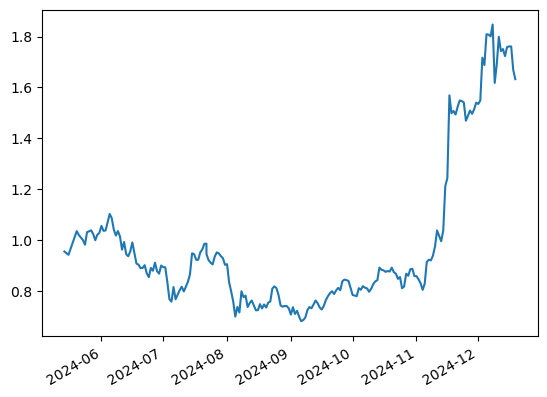

In [36]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [38]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [41]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [42]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'DOGEUSDT', 'DOTUSDT', 'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT',
       'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT',
       'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT',
       'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MKRUSDT',
       'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT', 'QNTUSDT', 'RAYUSDT',
       'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT',
       'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT',
       'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

In [43]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [46]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.4203
BNBUSDT,0.2050
SUIUSDT,0.1212
XRPUSDT,0.1035
PEPEUSDT,0.0985
TRXUSDT,0.0341
JASMYUSDT,0.0102
AAVEUSDT,0.0072
BONKUSDT,0.0000
ATOMUSDT,0.0000


In [47]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.395463
BTCUSDT,0.300000
SUIUSDT,0.100174
BNBUSDT,0.065600
PEPEUSDT,0.064095
XRPUSDT,0.046407
TRXUSDT,0.028261


### Current results

In [49]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [50]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.449508
OMUSDT,0.396746
TRXUSDT,0.153747


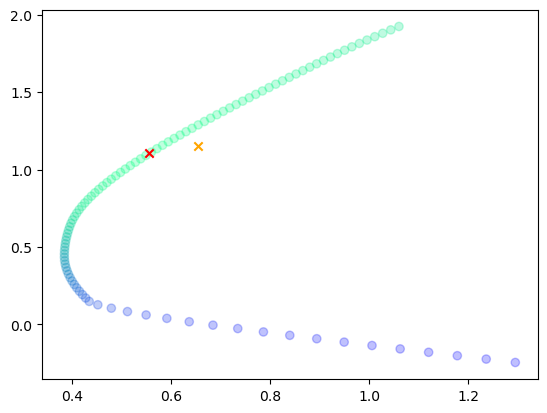

In [51]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [53]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1770.060188,0.465839,0.396746,0.069093
BTCUSDT,864.048458,0.227398,0.449508,-0.222111
JASMYUSDT,426.259488,0.112182,0.000000,0.000000
SOLUSDT,342.099963,0.090033,0.000000,0.000000
ETHUSDT,235.573023,0.061997,0.000000,0.000000
TRXUSDT,118.337680,0.031144,0.153747,-0.122603
BBUSDT,42.211062,0.011109,0.000000,0.000000
BNBUSDT,1.137897,0.000300,0.000000,0.000000
PEPEUSDT,0.000004,0.000000,0.000000,0.000000


In [54]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1770.060188,0.465839,0.395463,0.070376
BTCUSDT,864.048458,0.227398,0.300000,-0.072603
JASMYUSDT,426.259488,0.112182,0.000000,0.000000
SOLUSDT,342.099963,0.090033,0.000000,0.000000
ETHUSDT,235.573023,0.061997,0.000000,0.000000
TRXUSDT,118.337680,0.031144,0.028261,0.002883
BBUSDT,42.211062,0.011109,0.000000,0.000000
BNBUSDT,1.137897,0.000300,0.065600,-0.065301
PEPEUSDT,0.000004,0.000000,0.064095,-0.064095
SUIUSDT,0.000000,0.000000,0.100174,0.000000


# Risk Reward Analysis

In [56]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [57]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

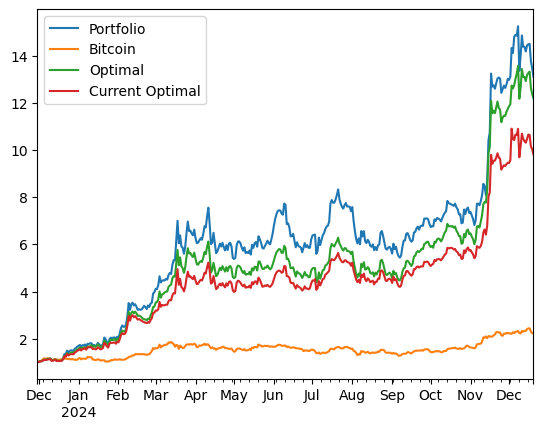

In [58]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [59]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

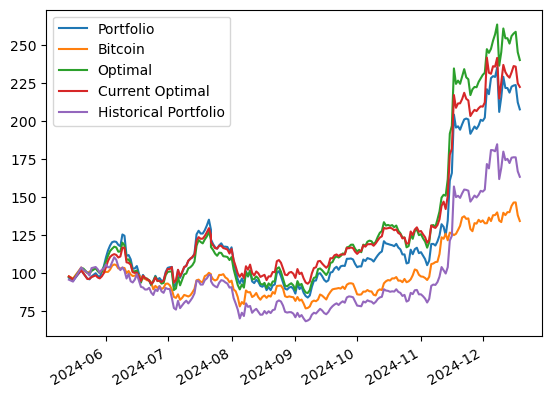

In [60]:
((1+current_perf).cumprod()*100).plot()

In [61]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-12-10,215.676175,133.504547,245.338225,225.286343,169.133901
2024-12-11,229.054159,139.625877,260.824010,236.882518,179.858235
2024-12-12,221.701088,138.069846,254.385909,232.116698,174.270669
2024-12-13,221.651963,140.016510,254.428262,229.831539,175.078776
2024-12-14,218.643466,140.010643,250.899241,228.491435,172.317363
2024-12-15,222.576370,144.151053,255.856339,231.969707,175.836410
2024-12-16,223.305636,146.334930,257.505826,236.107585,176.121825
2024-12-17,223.637754,146.438485,258.650291,235.733422,176.070219
2024-12-18,212.234765,138.019474,245.248310,224.743324,166.879687
2024-12-19,207.627980,134.189836,240.070767,222.375737,163.265422


## Volatilities

In [63]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.651583
 dtype: float64,
 0.6524021423320079)

In [64]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.655099
 dtype: float64,
 0.6550992385330422)

In [65]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.732678
Bitcoin            0.435162
Optimal            0.652402
Current Optimal    0.622934
dtype: float64

In [66]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4601211214116406

## Risk Contribution

In [68]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.096282,0.065600,0.007449,0.022483,0.002314,0.020168
BTCUSDT,0.371408,0.300000,0.030897,0.127472,0.040042,0.087430
OMUSDT,19.660608,0.395463,0.922933,0.697193,0.595040,0.102153
PEPEUSDT,0.234862,0.064095,0.013757,0.059041,0.015609,0.043432
SUIUSDT,0.270632,0.100174,0.017064,0.066706,0.021704,0.045001
TRXUSDT,0.020592,0.028261,0.002248,0.007491,0.000902,0.006589
XRPUSDT,0.076417,0.046407,0.005652,0.019615,0.002236,0.017379


In [69]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.968035,0.396746,0.610064,0.691169,0.573314,0.117855
BTCUSDT,0.197532,0.449508,0.289230,0.203452,0.111929,0.091523
TRXUSDT,0.071543,0.153747,0.100706,0.105379,0.059398,0.045981


In [70]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.146770,0.47,0.710905,0.698270,0.578668,0.119602
BTCUSDT,0.101072,0.23,0.145574,0.089134,0.021076,0.068058
JASMYUSDT,0.010674,0.11,0.053061,0.103654,0.034002,0.069651
SOLUSDT,0.007168,0.09,0.042725,0.060579,0.007874,0.052705
ETHUSDT,0.000675,0.06,0.026679,0.026812,0.002531,0.024281
TRXUSDT,0.013960,0.03,0.019329,0.011570,0.001627,0.009943
BBUSDT,-0.006077,0.01,0.001725,0.009982,0.000391,0.009591


# Value At Risk

## Historical

### Optimal Weights

In [74]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05150370658498041, -0.0755644519603845)

### Current Weights

In [76]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04922178859215046, -0.07507576203999208)

In [77]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [78]:
var=historical_var.iloc[row]
var

OMUSDT      -0.034865
BTCUSDT     -0.002147
JASMYUSDT   -0.006109
SOLUSDT     -0.002769
ETHUSDT     -0.001657
TRXUSDT     -0.000430
BBUSDT      -0.001246
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049222
Name: 2024-07-22 00:00:00, dtype: float64

In [79]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.043810
BTCUSDT     -0.008055
JASMYUSDT   -0.010172
SOLUSDT     -0.006128
ETHUSDT     -0.002861
TRXUSDT     -0.000974
BBUSDT      -0.000922
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072921
dtype: float64

## Parametric

### Optimal Weights

In [82]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06759932585487535, -0.08664364556747442)

### Current Weights

In [84]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06787878828015795, -0.08700183912960542)

## Multivariate

### Optimal Weights

In [87]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.060918383883940594, -0.07846349185772268)

### Current Weights

In [89]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06269342820809651, -0.079849591998518)

In [90]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.044311
BTCUSDT     -0.005310
JASMYUSDT   -0.006923
SOLUSDT     -0.003683
ETHUSDT     -0.001656
TRXUSDT     -0.000855
BBUSDT      -0.000629
Portfolio   -0.063367
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [94]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06008354882053719, -0.07601767379984627)

### Current Weights

In [96]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06319466507250426, -0.08012462113259829)

In [97]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.045018
BTCUSDT     -0.005611
JASMYUSDT   -0.006195
SOLUSDT     -0.003770
ETHUSDT     -0.001644
TRXUSDT     -0.000440
BBUSDT      -0.000601
Portfolio   -0.063277
dtype: float64

## Student Copula

### Optimal Weights

In [100]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05903470805786813, -0.07749349847874161)

### Current Weights

In [102]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06632270308067247, -0.08417848048613102)

In [103]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.045284
BTCUSDT     -0.005877
JASMYUSDT   -0.006158
SOLUSDT     -0.004218
ETHUSDT     -0.001767
TRXUSDT     -0.000731
BBUSDT      -0.000562
Portfolio   -0.064597
dtype: float64

## Gumbel Copula

### Optimal Weights

In [106]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1118588865779925, -0.1639239982022453)

### Current Weights

In [108]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11059045790054323, -0.1584591616353731)

In [109]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.104975
BTCUSDT     -0.005058
JASMYUSDT   -0.002494
SOLUSDT     -0.001722
ETHUSDT     -0.000500
TRXUSDT      0.000618
BBUSDT      -0.000355
Portfolio   -0.114485
dtype: float64

## Monte Carlo

### Optimal

In [112]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [113]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07058637521372729, -0.08747931438473165)

### Current Weights

In [115]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06966038889464592, -0.0863330096810628)

In [116]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.049195
BTCUSDT     -0.006480
JASMYUSDT   -0.006912
SOLUSDT     -0.004097
ETHUSDT     -0.001765
TRXUSDT     -0.000521
BBUSDT      -0.000557
Portfolio   -0.069528
dtype: float64

## VaR Violation

In [118]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.055966,-0.095732,-0.081253,-0.023666
2024-01-15,-0.055966,-0.095788,-0.083357,0.023614
2024-01-16,-0.055966,-0.095178,-0.076070,0.041424
2024-01-17,-0.055966,-0.097117,-0.076640,-0.028451
2024-01-18,-0.055966,-0.099997,-0.086519,-0.039206
...,...,...,...,...
2024-12-16,-0.086214,-0.108934,-0.099500,0.006447
2024-12-17,-0.086214,-0.073998,-0.070024,0.004444
2024-12-18,-0.087981,-0.075085,-0.072530,-0.051815
2024-12-19,-0.087981,-0.075748,-0.071850,-0.021111


In [119]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035735,-0.084148,-0.080413,-0.016855
2024-05-29,-0.035735,-0.081587,-0.075012,-0.008759
2024-05-30,-0.035735,-0.071378,-0.068417,0.034805
2024-05-31,-0.035735,-0.072497,-0.064685,0.038694
2024-06-01,-0.035735,-0.076207,-0.068176,0.053758
...,...,...,...,...
2024-12-16,-0.111162,-0.114585,-0.105610,0.003276
2024-12-17,-0.111162,-0.114653,-0.106499,0.001487
2024-12-18,-0.113807,-0.105728,-0.104229,-0.050989
2024-12-19,-0.113807,-0.106138,-0.107370,-0.021706


<Axes: >

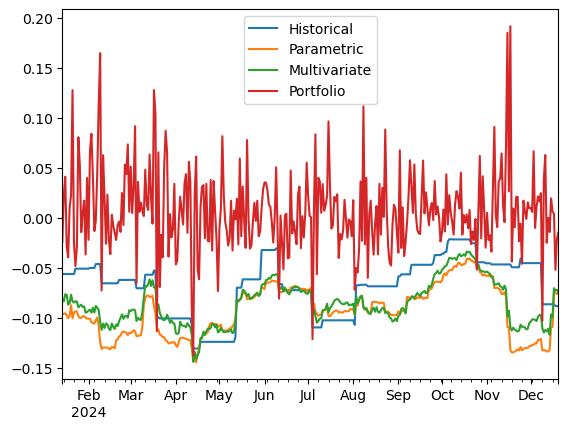

In [120]:
var_data.plot()

<Axes: >

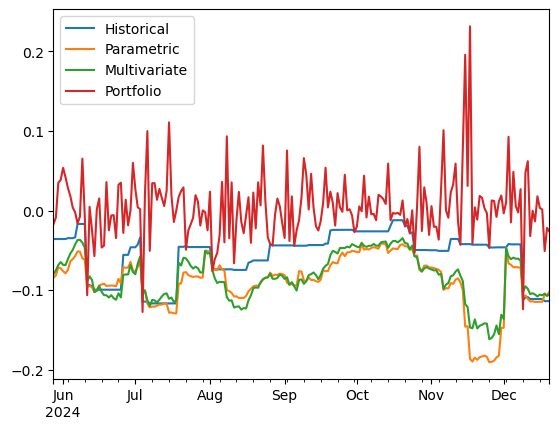

In [121]:
current_var_data.plot()

In [122]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.026316,0.011696,0.011696
Kupiec Stat,4.846912,15.098961,15.098961
P-value,0.027696,0.000102,0.000102


In [123]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.067633,0.019324,0.019324
Kupiec Stat,1.226153,5.297338,5.297338
P-value,0.268156,0.021358,0.021358


# Principal Component Analysis

## Historical PCA

In [126]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77031477, 0.07375433, 0.05832498, 0.05279078, 0.04481514])

In [127]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015219
ADAUSDT     0.015799
ALGOUSDT    0.017775
APTUSDT     0.016598
ARBUSDT     0.017479
              ...   
WBTCUSDT    0.009551
WLDUSDT     0.022639
XLMUSDT     0.012510
XRPUSDT     0.010950
XTZUSDT     0.016601
Name: PC1, Length: 61, dtype: float64

<Axes: >

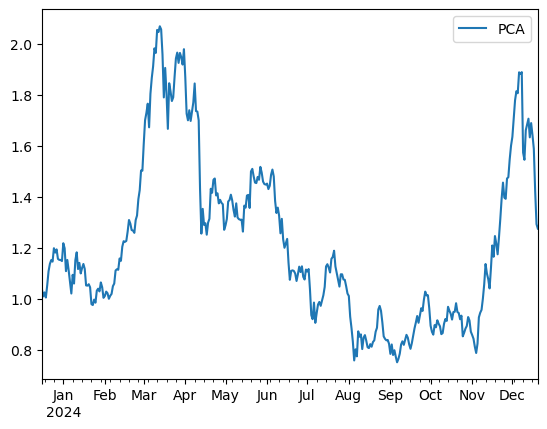

In [128]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

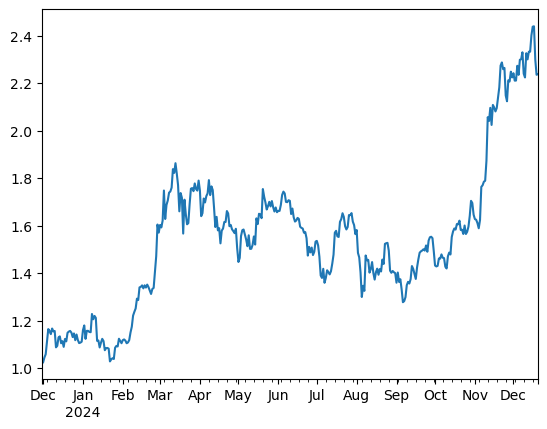

In [129]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [130]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.420945
ETHUSDT      0.426676
WBETHUSDT    0.426694
ATOMUSDT     0.451757
               ...   
FLOKIUSDT    1.128270
BONKUSDT     1.129664
WLDUSDT      1.135185
PEPEUSDT     1.182577
OMUSDT       1.538861
Length: 62, dtype: float64

<Axes: >

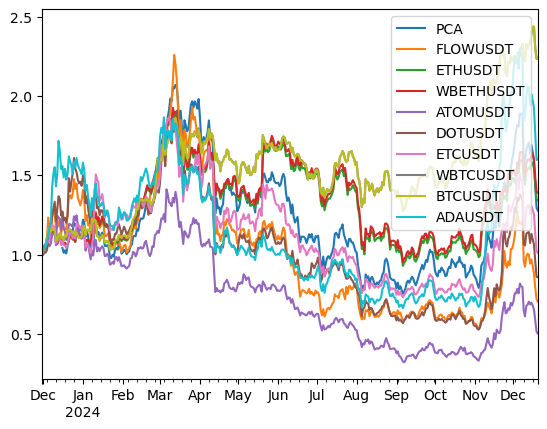

In [131]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

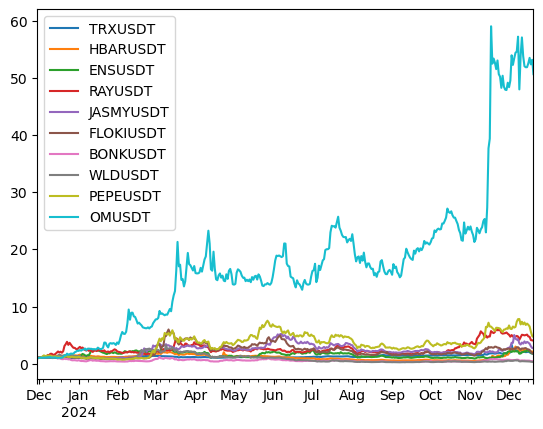

In [132]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [134]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.54025261, 0.15078201, 0.1315215 , 0.10279165, 0.07465223])

In [135]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.097058
BTCUSDT      0.061456
JASMYUSDT    0.168241
SOLUSDT      0.101009
ETHUSDT      0.083018
TRXUSDT      0.050835
BBUSDT       0.214036
BNBUSDT      0.066835
PEPEUSDT     0.157510
Name: PC1, dtype: float64

<Axes: >

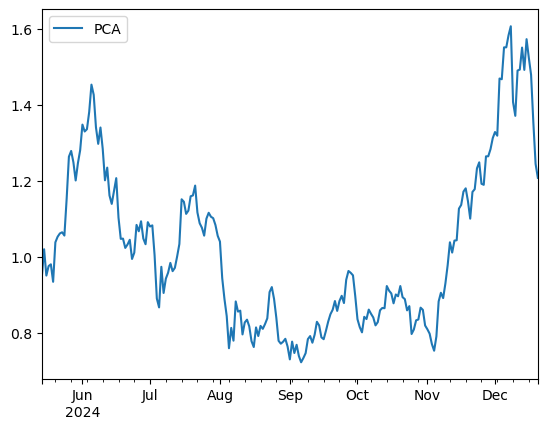

In [136]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

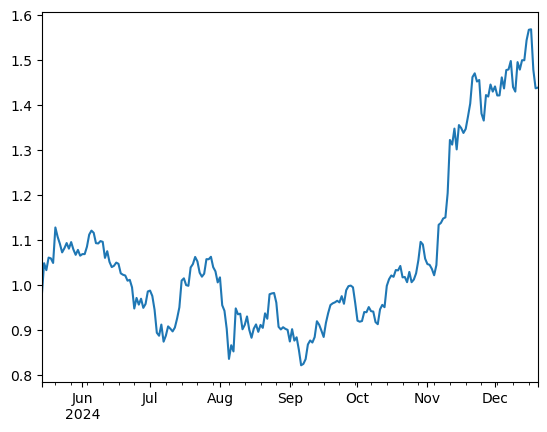

In [137]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [138]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SOLUSDT      0.395597
ETHUSDT      0.411900
BNBUSDT      0.423189
BTCUSDT      0.437595
JASMYUSDT    0.648268
PEPEUSDT     0.714929
BBUSDT       0.737979
TRXUSDT      0.886995
OMUSDT       0.897818
dtype: float64

<Axes: >

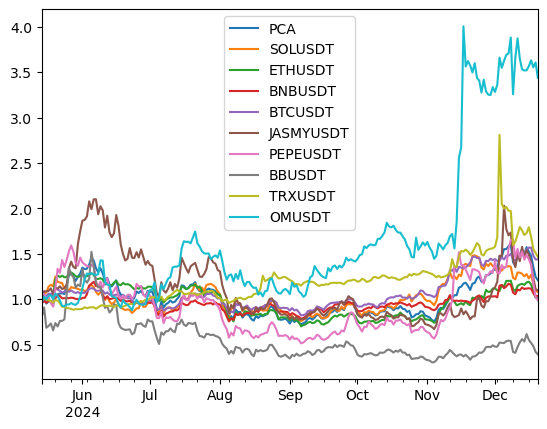

In [139]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [141]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.911697
BBUSDT       1.590999
JASMYUSDT    1.264270
SOLUSDT      1.147925
BTCUSDT      1.000000
ETHUSDT      0.962157
OMUSDT       0.880655
BNBUSDT      0.665157
TRXUSDT      0.282704
Name: BTCUSDT, dtype: float64

In [142]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.698314
JASMYUSDT    2.141685
PEPEUSDT     1.884040
TRXUSDT      1.485402
ETHUSDT      1.348961
SOLUSDT      1.255914
OMUSDT       1.029912
BTCUSDT      1.000000
BNBUSDT      0.963982
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [144]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [145]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.395763
ETHUSDT,0.288786
BNBUSDT,0.276598
BBUSDT,0.253391
OMUSDT,0.182374
JASMYUSDT,0.096453
PEPEUSDT,0.004644
TRXUSDT,-0.035839
SOLUSDT,-0.106150


### Regression to PCA

In [147]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.010329095165619

In [148]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.274797
BNBUSDT      1.134513
PCA          1.000000
ETHUSDT      0.989807
SOLUSDT      0.812757
JASMYUSDT    0.418319
PEPEUSDT     0.381980
BBUSDT       0.354789
OMUSDT       0.236393
TRXUSDT      0.197268
dtype: float64

In [149]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      2.034936
BNBUSDT      1.841252
ETHUSDT      1.500612
SOLUSDT      1.364056
PCA          1.000000
TRXUSDT      0.845119
JASMYUSDT    0.541113
OMUSDT       0.530791
BBUSDT       0.519663
PEPEUSDT     0.382610
dtype: float64

### Correlation Matrix

<Axes: >

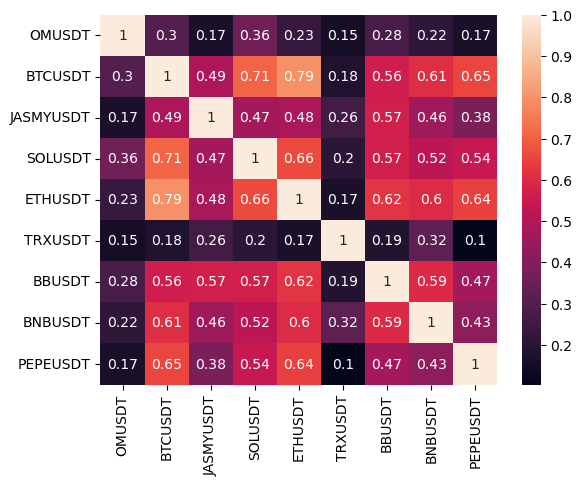

In [151]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

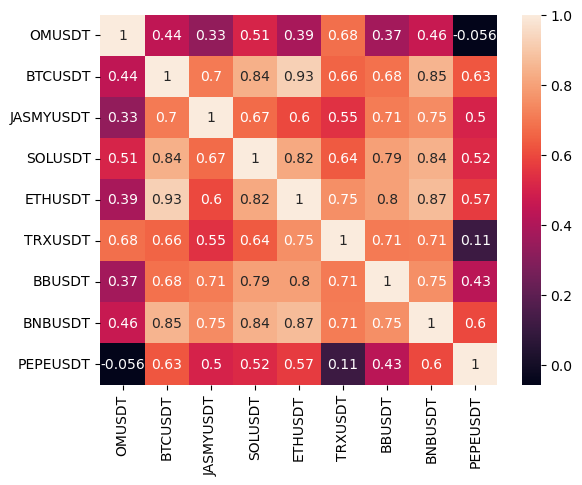

In [152]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [154]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [155]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-14,0.007532,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.758581,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-06-13,0.007546,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.086659,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-07-13,0.003586,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.979768,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-08-12,0.007546,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.135163,0.0
2024-09-11,0.573458,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.238195,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-10-11,0.007546,0.0,0.0,0.022774,0.0,0.0,0.0,0.0,0.0,0.0,...,0.434903,0.076894,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-11-10,0.007546,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-12-10,0.108787,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.040602,0.252969,0.0
2024-12-20,0.007546,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
